## E11. 폐렴 진단기 
이 프로젝트에서는 가슴 x-ray 이미지를 가지고 폐렴을 찾아내는 딥러닝 모델을 만들어 보았다. 데이터는 kaggle에서 가져왔고, 중국 광저우에 있는 여성 및 어린이 병원의 1-5세 사이의 가슴 x-ray 이미지다. 폐렴의 판단여부는(labeling) 의사들이 x-ray이미지를 보고 판단하였다고 한다. 

### Executive Summary 
* 모델에 여러가지 변수들을 바꿔보고 실험해본 결과 model4의 test accuracy rate이 0.883로 가장 높게 나왔다. 대신 recall rate은 original model보다 4% 정도 떨어졌다.  

* Model4     
1) Batch Normalization과 dropout은 보통 같이 쓰지 않는다고 한다. 모델에서 dropout을 빼줬다.       
2) original model 모델 보다 더 간단하게 만들어 주었다. 마지막 conv_block 하나를 없애주고 첫번째 Dense unit을 512에서 256으로 바꿔줬다.    
3) epoch=10 으로 낮춰줬다.         
  
metrics|Original Model|Model2|Model3|Model4    
---|---|---|---|---    
accuracy|0.82|0.875|0.79|0.883    
recall|0.99|0.951|1|0.949    

### 필요한 모듈 가져오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 데이터 가져오기
* tf.io.gfle.glob: Returns a list of files that match the given pattern(s).

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### train, validation 데이터셋 나눠주기 
* validation set이 상대적으로 적어서 train과 validation의 normal, pneumonia를 다 섞어서 8:2의 비율로 train:validation으로 나눠주었다. 
* train데이터의 pneumonia 이미지 수가 normal 보다 3배 더 많다. imbalanced data인 것을 확인할 수 있다. 
* tf.data.Dataset.from_tensor_slices: Creates a Dataset whose elements are slices of the given tensors. The given tensors are sliced along their first dimension. This operation preserves the structure of the input tensors, removing the first dimension of each tensor and using it as the dataset dimension. All input tensors must have the same size in their first dimensions.
* tf.data.experimental.cardinality: The operation returns the cardinality of dataset. 

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train file 개수: ', len(train_filenames))
print('validation file 개수: ', len(val_filenames))
print('train, validation 개수: ', (len(train_filenames)+len(val_filenames)))

4185
1047


In [9]:
train_filenames[:5]

['/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person53_bacteria_252.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1292_virus_2218.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1616_bacteria_4251.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1128-0001-0001.jpeg']

In [10]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [12]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [13]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 전처리 
* train, validation file마다 아래의 process수행 
    1. labeling: 폐렴이면 true, 정상이면 false
    2. image를 unit8 tensor로 수정 
    3. 2를 float32로 바꿔줌 
    4. 이미지를 180,180 resize해줌 
* test file 도 위와 같은 작업을 해 줌  
* prepare_for_training 함수를 통해서 아래의 process 수행 
    1. shuffle: buffer_size를 유지하면서 무작위로 요소 선택 
    2. repeat: Repeats this dataset so each original value is seen count times.
    3. batch(BATCH_SIZE): batch size만큼의 batch로 주어짐 
    4. prefetch: 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다. 

In [14]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [15]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [16]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [17]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [18]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [19]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화 

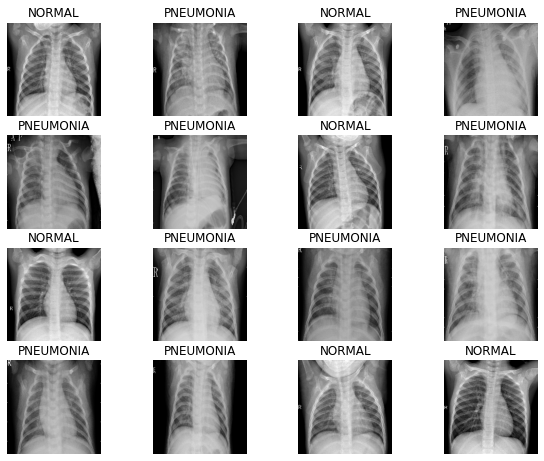

In [20]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 모델 만들기 
1. CNN 모델 구조     
    1) 2D/2D/Maxpool2D     
    2) conv_block 3번. conv block에 있는 요소    
        * SeparableConv2D 2번     
        * batch normalization     
        * maxpool2D   
    3) dropout    
    4) conv_block   
    5) dropout   
    6) Flatten     
    7) dense_block 3번    
        * dense   
        * batch normalization    
        * dropout    
    8) Dense (activation='sigmoid')  

In [21]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [22]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [23]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### imbalanced data의 weight조정 

In [24]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 모델훈련 

In [25]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 57s 138ms/step - loss: 0.5155 - accuracy: 0.7354 - precision: 0.9256 - recall: 0.6995 - val_loss: 0.6681 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2415 - accuracy: 0.9098 - precision: 0.9726 - recall: 0.9049 - val_loss: 1.6088 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 129ms/step - loss: 0.1893 - accuracy: 0.9235 - precision: 0.9795 - recall: 0.9168 - val_loss: 0.2266 - val_accuracy: 0.8981 - val_precision: 0.8793 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1910 - accuracy: 0.9242 - precision: 0.9736 - recall: 0.9219 - val_loss: 0.1970 - val_accuracy: 0.9163 - val_precision: 0.8978 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 34s 129ms/step - loss: 0.1709 - accura

### 평가

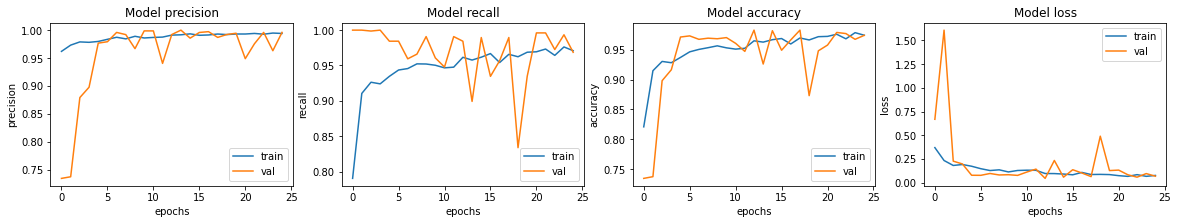

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 76ms/step - loss: 1.0924 - accuracy: 0.8189 - precision: 0.7798 - recall: 0.9897
Loss: 1.0923731327056885,
Accuracy: 0.8189102411270142,
Precision: 0.7797979712486267,
Recall: 0.9897435903549194


### 모델 성능 올리기  
* 변수 바꿔주기
    * batch size를 16에서 32로 바꿔주기 
    * epoch도 조정해줬다.  
* data augmentation: 프로젝트에 사용된 데이터의 레이블링은 의사가 직접 X-RAY를 보고 판단한 결과이다. 새로 생성된 데이터의 레이블링을 의사에게 확인받을 수 없기때문에 data augmentation기법을 사용할 때는 신중해야 한다. 아니면 모델의 정확도를 더 떨어트리는 부작용을 가져올 수 있다. 고민끝에 data augmentation 기법은 쓰지 않기로 한다. [출처](https://www.frontiersin.org/articles/10.3389/fmed.2021.629134/full) 
* Early Stopping (val_accuracy, val_loss)을 모델 훈련시킬때 추가해 줬는데 성능개선이 안 돼서 다시 빼버렸다.  

### Model 2   
1) filter 크기 3에서 4로 조정     
2) dropout rate 조정      
3) epoch=10    
4) accuracy=0.88 , recall=0.95     

In [36]:
BATCH_SIZE_NEW = 32

In [30]:
def build_model2():
    model2 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 4, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 4, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3), # changed from 0.2
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3), # changed from 0.2
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5), # changed from 0.7
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model2

In [29]:
from keras.callbacks import EarlyStopping

In [47]:
#es = EarlyStopping(monitor='val_accuracy', patience=3)

In [44]:
with tf.device('/GPU:0'):
    model2 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [50]:
with tf.device('/GPU:0'):
    history2_2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_NEW,
        epochs=10,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_NEW,
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 26s 164ms/step - loss: 0.1876 - accuracy: 0.9260 - precision: 0.9782 - recall: 0.9218 - val_loss: 0.3797 - val_accuracy: 0.8516 - val_precision: 1.0000 - val_recall: 0.8000
Epoch 2/10
130/130 [==============================] - 21s 162ms/step - loss: 0.1798 - accuracy: 0.9399 - precision: 0.9809 - recall: 0.9367 - val_loss: 0.1333 - val_accuracy: 0.9570 - val_precision: 0.9602 - val_recall: 0.9847
Epoch 3/10
130/130 [==============================] - 21s 162ms/step - loss: 0.2020 - accuracy: 0.9197 - precision: 0.9726 - recall: 0.9178 - val_loss: 0.1991 - val_accuracy: 0.9316 - val_precision: 0.9940 - val_recall: 0.9096
Epoch 4/10
130/130 [==============================] - 21s 162ms/step - loss: 0.1551 - accuracy: 0.9404 - precision: 0.9857 - recall: 0.9335 - val_loss: 0.0841 - val_accuracy: 0.9648 - val_precision: 0.9639 - val_recall: 0.9894
Epoch 5/10
130/130 [==============================] - 21s 163ms/step - loss: 0.1628 - accura

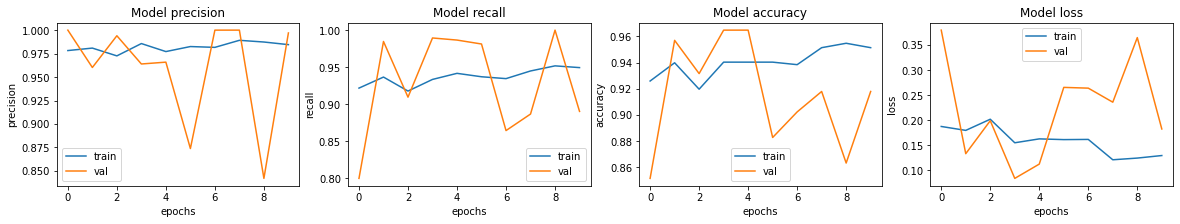

In [56]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2_2.history[met])
    ax[i].plot(history2_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.3160 - accuracy: 0.8750 - precision: 0.8628 - recall: 0.9513
Loss: 0.315973699092865,
Accuracy: 0.875,
Precision: 0.8627907037734985,
Recall: 0.9512820243835449


### Model3   
1) conv_bloc뒤 dropout 없애줌     
2) epoch=15    
3) accuracy=0.79 , recall=1  

In [57]:
def build_model3():
    model3 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
               
        conv_block(256),
                
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5), # changed from 0.7
        dense_block(128, 0.5),
        dense_block(64, 0.5), # changed from 0.3
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model3

In [58]:
with tf.device('/GPU:0'):
    model3 = build_model3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [59]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_NEW,
        epochs=15,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_NEW,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 27s 156ms/step - loss: 0.5262 - accuracy: 0.7316 - precision: 0.9354 - recall: 0.6845 - val_loss: 0.5997 - val_accuracy: 0.7129 - val_precision: 0.7129 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 19s 148ms/step - loss: 0.2633 - accuracy: 0.8816 - precision: 0.9744 - recall: 0.8609 - val_loss: 0.6413 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 19s 147ms/step - loss: 0.2475 - accuracy: 0.8988 - precision: 0.9704 - recall: 0.8910 - val_loss: 0.8261 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 19s 148ms/step - loss: 0.1892 - accuracy: 0.9276 - precision: 0.9754 - recall: 0.9244 - val_loss: 1.3545 - val_accuracy: 0.7598 - val_precision: 0.7598 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 19s 148ms/step - loss: 0.1989 - accura

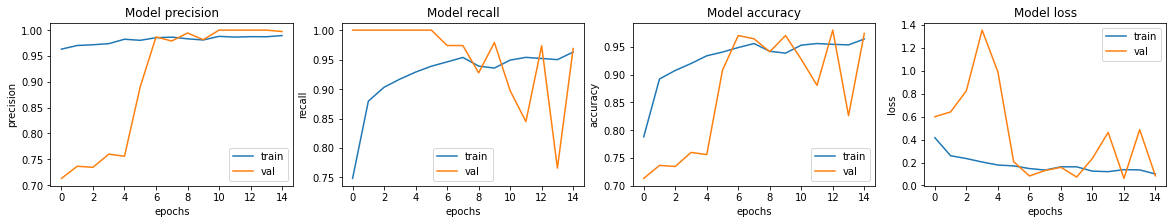

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [73]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 72ms/step - loss: 0.6576 - accuracy: 0.7949 - precision: 0.7539 - recall: 0.9974
Loss: 0.6576070785522461,
Accuracy: 0.7948718070983887,
Precision: 0.7538759708404541,
Recall: 0.9974358677864075


### Model4 
1) dropout 없애줌   
2) conv_block 하나를 없애줌       
3) epoch=10         
4) accuracy=0.88 , recall=0.95  

In [62]:
def dense_block_new(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

In [67]:
def build_model4():
    model4 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        #conv_block(256),
                
        tf.keras.layers.Flatten(),
        dense_block_new(256), # changed from 512
        dense_block_new(128),
        dense_block_new(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model4

In [68]:
with tf.device('/GPU:0'):
    model4 = build_model4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [69]:
with tf.device('/GPU:0'):
    history4 = model4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_NEW,
        epochs=10,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_NEW,
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 27s 152ms/step - loss: 0.2823 - accuracy: 0.8586 - precision: 0.9630 - recall: 0.8397 - val_loss: 0.5828 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 19s 148ms/step - loss: 0.2000 - accuracy: 0.9134 - precision: 0.9793 - recall: 0.9032 - val_loss: 0.8067 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 19s 147ms/step - loss: 0.1486 - accuracy: 0.9407 - precision: 0.9838 - recall: 0.9370 - val_loss: 0.6133 - val_accuracy: 0.7598 - val_precision: 0.7598 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 19s 146ms/step - loss: 0.1564 - accuracy: 0.9409 - precision: 0.9792 - recall: 0.9394 - val_loss: 0.8483 - val_accuracy: 0.7285 - val_precision: 0.7285 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 19s 145ms/step - loss: 0.1243 - accura

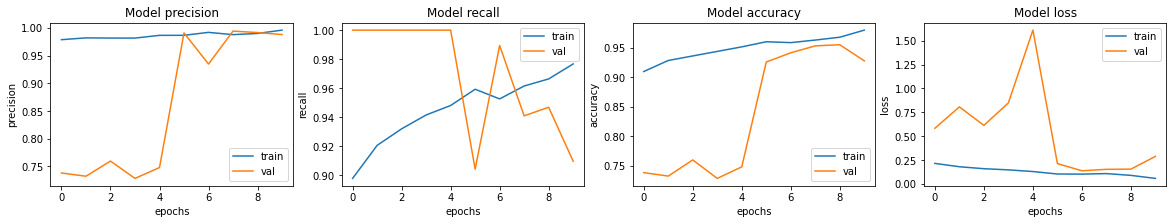

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [70]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.4181 - accuracy: 0.8830 - precision: 0.8747 - recall: 0.9487
Loss: 0.4181027412414551,
Accuracy: 0.8830128312110901,
Precision: 0.8747044801712036,
Recall: 0.9487179517745972
